# **Project: Amazon Product Recommendation System**




Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Installing surprise library**

In [ ]:
# Installing the surprise library
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 2.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357231 sha256=4b5f68655477ff0f0efe42c08c9c95c692cb384873f41a9c4a4911105ee7065b
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


## **Importing the necessary libraries and overview of the dataset**

In [ ]:
import warnings                                 # Used to ignore the warning given as output of the code
warnings.filterwarnings('ignore')

import numpy as np                              # Basic libraries of python for numeric and dataframe computations
import pandas as pd

import matplotlib.pyplot as plt                 # Basic library for data visualization
import seaborn as sns                           # Slightly advanced library for data visualization

from collections import defaultdict             # A dictionary output that does not raise a key error

from sklearn.metrics import mean_squared_error  # A performance metrics in sklearn


### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [ ]:
# Importing the "ratings_Electronics.csv" dataset
ratings = pd.read_csv('/content/drive/MyDrive/Colab/Elective_Project/ratings_Electronics.csv')

In [ ]:
# Info of the dataframe
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824481 entries, 0 to 7824480
Data columns (total 4 columns):
 #   Column         Dtype  
---  ------         -----  
 0   AKM1MP6P0OYPR  object 
 1   0132793040     object 
 2   5.0            float64
 3   1365811200     int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [ ]:
# head() is a method used to display the first n records of a dataframe, by default n=5.
ratings.head()

,AKM1MP6P0OYPR,0132793040,5.0,1365811200
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [ ]:
# As the file doesn't have column heads, let's read it again with option header=None.
ratings = pd.read_csv('/content/drive/MyDrive/Colab/Elective_Project/ratings_Electronics.csv', header=None)

# Add column names.
ratings.columns = ['user_id', 'prod_id', 'rating','timestamp']

# Check info again.
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   user_id    object 
 1   prod_id    object 
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [ ]:
# drop() is a method used to remove the desired columns/rows from a dataframe
ratings = ratings.drop(['timestamp'], axis = 1)

In [ ]:
# Copy the data to another DataFrame called df and display head again.
df = ratings.copy()
df.head()

,user_id,prod_id,rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [ ]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [ ]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [ ]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [ ]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [ ]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


In [ ]:
# Check info again.
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65290 entries, 1310 to 7824427
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB




*   The no. of records has been cut down to 65290.



## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [ ]:
# Check the number of rows and columns and provide observations
df_final.shape

(65290, 3)



*   In the data, there are **65,290 rows** and **3 columns**.




### **Data types**

In [ ]:
# Check Data types and provide observations
df_final.info()
df_final.head()

<class 'pandas.core.frame.DataFrame'>
Index: 65290 entries, 1310 to 7824427
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0



*   The two id columns user_id and prod_id are object data type, contain strings.
*   The rating column is numeric data type.



**Let's transfer the two id columns to string data type.**


In [ ]:
df_final['user_id'] = df_final['user_id'].astype('string')
df_final['prod_id'] = df_final['prod_id'].astype('string')

### **Checking for missing values**

In [ ]:
# Check for missing values present and provide observations
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65290 entries, 1310 to 7824427
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  string 
 1   prod_id  65290 non-null  string 
 2   rating   65290 non-null  float64
dtypes: float64(1), string(2)
memory usage: 2.0 MB




**Further check the unique values of all the columns.**




In [ ]:
print('There are ',df_final['user_id'].nunique(), 'users.\n')
print('There are ',df_final['prod_id'].nunique(), 'products.\n')
print('The possible ratings are: ',df_final['rating'].unique(),'\n')

There are  1540 users.

There are  5689 products.

The possible ratings are:  [5. 1. 3. 4. 2.] 



**Double check if there are duplicate entries.**

In [ ]:
# Check if there are duplicate entries
df_final.duplicated().sum()

0

In [ ]:
# Finding the sum of ratings count by user-product pair
df_final.groupby(['user_id', 'prod_id']).count()['rating'].sum()

65290



*   The data are pretty clean. No missing values and No duplicate entries.



### **Summary Statistics**

In [ ]:
# Summary statistics of 'rating' variable and provide observations
df_final.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
user_id,65290,1540,ADLVFFE4VBT8,295,NaN,NaN,NaN,NaN,NaN,NaN,NaN
prod_id,65290,5689,B0088CJT4U,206,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rating,65290.0,NaN,NaN,NaN,4.294808,0.988915,1.0,4.0,5.0,5.0,5.0




*   Average rating is ~4.29. Over 50% rating are 5.


### **Checking the rating distribution**

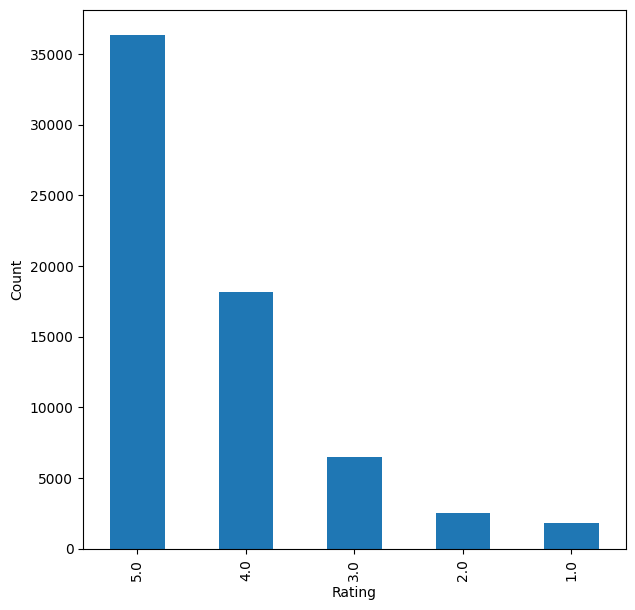

In [ ]:
# Create the bar plot and provide observations

plt.figure(figsize = (7, 7))

df_final['rating'].value_counts().plot(kind = 'bar')

# This gives a label to the variable on the x-axis
plt.xlabel('Rating')

# This gives a label to the variable on the y-axis
plt.ylabel('Count')

# This displays the plot
plt.show()

In [ ]:
print(df_final['rating'].value_counts())
print(df_final['rating'].value_counts(normalize=True))

rating
5.0    36315
4.0    18127
3.0     6481
2.0     2515
1.0     1852
Name: count, dtype: int64
rating
5.0    0.556211
4.0    0.277638
3.0    0.099265
2.0    0.038520
1.0    0.028366
Name: proportion, dtype: float64


*   Among the 65290 ratings, ~55.6% are rating 5, ~27.8% are rating 4, the percentages for rating 1-3 are pretty small.

### **Checking the number of unique users and items in the dataset**

In [ ]:
# Number of total rows in the data and number of unique user id and product id in the data
print("There are", df_final.shape[0], 'rows.\n')
print('There are ',df_final['user_id'].nunique(), 'users.\n')
print('There are ',df_final['prod_id'].nunique(), 'products.\n')

There are 65290 rows.

There are  1540 users.

There are  5689 products.





*   There are total 65290 rows, 1540 unique user id and 5689 unique product id in the data.





### **Users with the most number of ratings**

In [ ]:
# Top 10 users based on the number of ratings

df_final.groupby('user_id').count().sort_values(by = 'rating', ascending = False).head(10)



,prod_id,rating
user_id,,
ADLVFFE4VBT8,295,295
A3OXHLG6DIBRW8,230,230
A1ODOGXEYECQQ8,217,217
A36K2N527TXXJN,212,212
A25C2M3QF9G7OQ,203,203
A680RUE1FDO8B,196,196
A22CW0ZHY3NJH8,193,193
A1UQBFCERIP7VJ,193,193
AWPODHOB4GFWL,184,184




*   Top 10 users (based on the number of ratings) made 179-295 ratings. They are much smaller than the number of products in the data. We can build a recommendation system to recommend products to users which they have not interacted with.



**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [ ]:
# Calculate the average rating for each product
average_rating = df_final.groupby('prod_id')['rating'].mean()

# Calculate the count of ratings for each product
count_rating = df_final.groupby('prod_id')['rating'].count()

# Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'avg_rating': average_rating, 'rating_count': count_rating})

# Sort the dataframe by average of ratings in the descending order
final_rating = final_rating.sort_values(by = 'avg_rating', ascending = False)

# See the first five records of the "final_rating" dataset
final_rating.head()

,avg_rating,rating_count
prod_id,,
B00LGQ6HL8,5.0,5
B003DZJQQI,5.0,14
B005FDXF2C,5.0,7
B00I6CVPVC,5.0,7
B00B9KOCYA,5.0,8


In [ ]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def top_n_products(data, n, min_interaction = 100):

# Finding products with minimum number of interactions
    recommendations = data[data['rating_count'] > min_interaction]

# Sorting values with respect to average rating
    recommendations = recommendations.sort_values(by = 'avg_rating', ascending = False)

    return recommendations.index[:n]

### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [ ]:
list(top_n_products(final_rating, 5, 50))

['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW']

### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [ ]:
list(top_n_products(final_rating, 5, 100))

['B003ES5ZUU', 'B000N99BBC', 'B007WTAJTO', 'B002V88HFE', 'B004CLYEDC']

We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [ ]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [ ]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [ ]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale = (0, 5))

# Loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size = 0.2, random_state = 42)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [ ]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': True}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
sim_user_user = KNNBasic(sim_options = sim_options, verbose = False, random_state = 1)

# Fit the model on the training data
sim_user_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(sim_user_user)

RMSE: 1.0012
Precision:  0.855
Recall:  0.858
F_1 score:  0.856


- We have calculated **RMSE** to check **how far the overall predicted ratings** are from the **actual ratings**.
- Intuition of Recall: We are getting a **recall of ~0.86**, which means out of **all the relevant movies 86% are recommended**.
- Intuition of Precision: We are getting a **precision of ~ 0.86**, which means **out of all the recommended movies 86% are relevant**.
- Here **F_1 score** of the **baseline model is ~0.86**. It indicates that **mostly recommended movies were relevant and relevant movies were recommended**. We will try to improve this later by using **GridSearchCV by tuning different hyperparameters** of this algorithm.

Let's now **predict rating for a user with `userId=A3CW0ZLUO5X2B1` and `productId=B003ES5ZUU`** as shown below. Here the user has already interacted or watched the product with productId 'B003ES5ZUU' and given a rating of 5.

In [ ]:
# Predicting rating for a sample user with an interacted product
sim_user_user.predict('A3CW0ZLUO5X2B1', 'B003ES5ZUU', r_ui = 5, verbose = True)

user: A3CW0ZLUO5X2B1 item: B003ES5ZUU r_ui = 5.00   est = 4.95   {'actual_k': 40, 'was_impossible': False}


Prediction(uid='A3CW0ZLUO5X2B1', iid='B003ES5ZUU', r_ui=5, est=4.95, details={'actual_k': 40, 'was_impossible': False})

- The above output shows that **the actual rating 5 is close to the predicted rating 4.95 for this user-item pair** by this **user-user-similarity-based baseline model**.
- The **output** also contains **"actual_k"**. It is the value of **K in KNN** that is used while training the model. The default value is 40.

Below is the function to find the **list of users who have not seen the product with product id "B003ES5ZUU"**.

In [ ]:
def n_users_not_interacted_with(n, data, prod_id):
    users_interacted_with_product = set(data[data['prod_id'] == prod_id]['user_id'])
    all_users = set(data['user_id'])
    return list(all_users.difference(users_interacted_with_product))[:n] # where n is the number of elements to get in the list

In [ ]:
# Find unique user_id where prod_id is not equal to "1400501466"
n_users_not_interacted_with(5, df_final, 'B003ES5ZUU')

['A4UGMKUSX9XHI',
 'A37CEYB95LK6R6',
 'A20L63B48RPSOH',
 'ABH9D1TEOJ56E',
 'A1KWPIORLG2QV']

* It can be observed from the above list that **user "A4UGMKUSX9XHI" has not seen the product with productId "B003ES5ZUU"** as this user id is a part of the above list.

**Below we are predicting rating for `userId=A4UGMKUSX9XHI` and `prod_id=B003ES5ZUU`.**

In [ ]:
# Predicting rating for a sample user with a non interacted product
sim_user_user.predict('A4UGMKUSX9XHI', 'B003ES5ZUU', verbose = True)

user: A4UGMKUSX9XHI item: B003ES5ZUU r_ui = None   est = 4.95   {'actual_k': 40, 'was_impossible': False}


Prediction(uid='A4UGMKUSX9XHI', iid='B003ES5ZUU', r_ui=None, est=4.95, details={'actual_k': 40, 'was_impossible': False})

Above, we have **predicted the rating for this user-item pair** based on this user-user similarity-based baseline model.

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [30, 40, 50], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
              }

# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting the data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9723925608495966
{'k': 40, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [ ]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'cosine',
               'user_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(sim_options = sim_options, k = 40, min_k = 6, random_state = 1, verbose = False)

# Training the algorithm on the trainset
sim_user_user_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(sim_user_user_optimized)

RMSE: 0.9526
Precision:  0.847
Recall:  0.894
F_1 score:  0.87


- We can see from above that after tuning hyperparameters, **F_1 score of the tuned model has increased in comparison to the baseline model**. Along with this, **the RMSE of the model has gone down as compared to the model before hyperparameter tuning**. Hence, we can say that the model performance has improved slightly after hyperparameter tuning.

### **Steps:**
- **Predict rating for the user with `userId="A3CW0ZLUO5X2B1"`, and `prod_id= "B003ES5ZUU"` using the optimized model**
- **Predict rating for `userId="A4UGMKUSX9XHI"` who has not interacted with `prod_id ="B003ES5ZUU"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A3CW0ZLUO5X2B1" and productId "B003ES5ZUU"
sim_user_user_optimized.predict('A3CW0ZLUO5X2B1', 'B003ES5ZUU', r_ui = 5, verbose = True)

user: A3CW0ZLUO5X2B1 item: B003ES5ZUU r_ui = 5.00   est = 4.95   {'actual_k': 40, 'was_impossible': False}


Prediction(uid='A3CW0ZLUO5X2B1', iid='B003ES5ZUU', r_ui=5, est=4.95, details={'actual_k': 40, 'was_impossible': False})

- **The predicted rating by the tuned model is exactly the same as the prediction by the baseline model, also close to the actual rating.**

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A4UGMKUSX9XHI" and productId "B003ES5ZUU"
sim_user_user_optimized.predict('A4UGMKUSX9XHI', 'B003ES5ZUU', verbose = True)

user: A4UGMKUSX9XHI item: B003ES5ZUU r_ui = None   est = 4.95   {'actual_k': 40, 'was_impossible': False}


Prediction(uid='A4UGMKUSX9XHI', iid='B003ES5ZUU', r_ui=None, est=4.95, details={'actual_k': 40, 'was_impossible': False})

- **The predicted rating for this user-item pair is exactly the same as the prediction by the baseline model.**

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `cosine` distance metric.

In [ ]:
# 0 is the inner id of the above user
sim_user_user_optimized.get_neighbors(0, k = 5)

[6, 7, 17, 26, 32]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [ ]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3CW0ZLUO5X2B1" with similarity based recommendation system**

In [ ]:
# Making top 5 recommendations for user_id "A3CW0ZLUO5X2B1" with a similarity-based recommendation engine
recommendations = get_recommendations(df_final, 'A3CW0ZLUO5X2B1', 5, sim_user_user_optimized)

In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,B000067RVL,5
1,B00006HSML,5
2,B00006I5J7,5
3,B0000B006W,5
4,B00011KM38,5


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [ ]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': False}

# KNN algorithm is used to find desired similar items. Use random_state=1
sim_item_item = KNNBasic(sim_options = sim_options, random_state = 1, verbose = False)

# Train the algorithm on the trainset, and predict ratings for the test set
sim_item_item.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(sim_item_item)

RMSE: 0.9950
Precision:  0.838
Recall:  0.845
F_1 score:  0.841


- Here, **F_1 score** of the **baseline model** is **~0.84**. We will try to improve this later by tuning different hyperparameters of this algorithm using **GridSearchCV**.

Let's now **predict a rating for a user with `userId = A3CW0ZLUO5X2B1` and `prod_Id = B003ES5ZUU`** as shown below. Here the user has already interacted or watched the product with productId "B003ES5ZUU".

In [ ]:
# Predicting rating for a sample user with an interacted product
sim_item_item.predict('A3CW0ZLUO5X2B1', 'B003ES5ZUU', r_ui = 5, verbose = True)

user: A3CW0ZLUO5X2B1 item: B003ES5ZUU r_ui = 5.00   est = 4.75   {'actual_k': 40, 'was_impossible': False}


Prediction(uid='A3CW0ZLUO5X2B1', iid='B003ES5ZUU', r_ui=5, est=4.749962359814508, details={'actual_k': 40, 'was_impossible': False})

- The above output shows that **the predicted rating for this user-item pair is still close to the actual rating 5.** But it's a little underestimated in comparision to the optimized user-user model.

Below we are **predicting rating for the `userId = A4UGMKUSX9XHI` and `prod_id = B003ES5ZUU`**.

In [ ]:
# Predicting rating for a sample user with a non interacted product
sim_item_item.predict('A4UGMKUSX9XHI', 'B003ES5ZUU', verbose = True)

user: A4UGMKUSX9XHI item: B003ES5ZUU r_ui = None   est = 4.72   {'actual_k': 32, 'was_impossible': False}


Prediction(uid='A4UGMKUSX9XHI', iid='B003ES5ZUU', r_ui=None, est=4.722776571698674, details={'actual_k': 32, 'was_impossible': False})

Above, we have **predicted the rating for this user-item pair** based on this item-item similarity-based baseline model. It's also a little underestimated in comparision to the optimized user-user model.

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}
              }

# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting the data
gs.fit(data)

# Find the best RMSE score
print(gs.best_score['rmse'])

# Find the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9735498572957674
{'k': 20, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [ ]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = {'name': 'msd',
               'user_based': False}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimized = KNNBasic(sim_options = sim_options, k = 20, min_k = 6, random_state = 1, verbose = False)

# Training the algorithm on the trainset
sim_item_item_optimized.fit(trainset)

# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(sim_item_item_optimized)

RMSE: 0.9578
Precision:  0.839
Recall:  0.88
F_1 score:  0.859


- We can observe that after tuning hyperparameters, **F_1 score of the model is a bit better than the baseline model**. Along with this, **the RMSE of the model has gone down in comparison to the model with default hyperparameters**. Hence, we can say that the model performance has improved after hyperparameter tuning.

### **Steps:**
- **Predict rating for the user with `userId="A3CW0ZLUO5X2B1"`, and `prod_id= "B003ES5ZUU"` using the optimized model**
- **Predict rating for `userId="A4UGMKUSX9XHI"` who has not interacted with `prod_id ="B003ES5ZUU"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
sim_item_item_optimized.predict('A3CW0ZLUO5X2B1', 'B003ES5ZUU', r_ui = 5, verbose = True)

user: A3CW0ZLUO5X2B1 item: B003ES5ZUU r_ui = 5.00   est = 5.00   {'actual_k': 20, 'was_impossible': False}


Prediction(uid='A3CW0ZLUO5X2B1', iid='B003ES5ZUU', r_ui=5, est=5, details={'actual_k': 20, 'was_impossible': False})

- **The predicted rating is exactly the same as the actual rating, we can say that the predicted rating by the tuned model is closer to the actual rating in comparison to the prediction by the baseline model**.

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A10O7THJ2O20AG" and productId "1400501466"
sim_item_item_optimized.predict('A4UGMKUSX9XHI', 'B003ES5ZUU', verbose = True)

user: A4UGMKUSX9XHI item: B003ES5ZUU r_ui = None   est = 4.84   {'actual_k': 20, 'was_impossible': False}


Prediction(uid='A4UGMKUSX9XHI', iid='B003ES5ZUU', r_ui=None, est=4.8378865205643935, details={'actual_k': 20, 'was_impossible': False})

- **The predicted rating for this user-item pair is close to the one predicted by the baseline model.**


- **After tuning, it looks like the previous underestimation problem has been solved.**

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [ ]:
sim_item_item_optimized.get_neighbors(0, k = 5)

[29, 53, 67, 106, 151]

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [ ]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommendations = get_recommendations(df_final, 'A1A5KUIIIHFF4U', 5, sim_item_item_optimized)

In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,1400532655,4.292024
1,1400599997,4.292024
2,9983891212,4.292024
3,B00000DM9W,4.292024
4,B00000J1V5,4.292024


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [ ]:
# Using SVD matrix factorization. Use random_state = 1
svd = SVD(random_state = 1)

# Training the algorithm on the trainset
svd.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd)

RMSE: 0.8882
Precision:  0.853
Recall:  0.88
F_1 score:  0.866


- We can observe that the **F_1 score** for the matrix factorization model on the test set is a little bit lower in comparison to the F_1 score for the optimized user-user similarity-based recommendation system, but is higher in comparison to the F_1 score for the optimized item-item similarity-based recommendation system. And it's RMSE is the lowest among the three.

**Let's now predict the rating for a user with `userId = "A3CW0ZLUO5X2B1"` and `prod_id = "B003ES5ZUU".**

In [ ]:
# Making prediction
svd.predict('A3CW0ZLUO5X2B1', 'B003ES5ZUU', r_ui = 5, verbose = True)

user: A3CW0ZLUO5X2B1 item: B003ES5ZUU r_ui = 5.00   est = 4.86   {'was_impossible': False}


Prediction(uid='A3CW0ZLUO5X2B1', iid='B003ES5ZUU', r_ui=5, est=4.864914228961245, details={'was_impossible': False})

- The above output shows that **the predicted rating for this user-item pair is close to the actual rating 5.**

**Below we are predicting rating for the `userId = "A4UGMKUSX9XHI"` and `productId = "B003ES5ZUU"`.**

In [ ]:
# Making prediction
svd.predict('A4UGMKUSX9XHI', 'B003ES5ZUU', verbose = True)

user: A4UGMKUSX9XHI item: B003ES5ZUU r_ui = None   est = 5.00   {'was_impossible': False}


Prediction(uid='A4UGMKUSX9XHI', iid='B003ES5ZUU', r_ui=None, est=5, details={'was_impossible': False})

- **The predicted the rating for this user-item pair is also closed to the one predicted by optimized user-user similarity-based model and optimized item-item similarity-based model.**

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [ ]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross-validation
gs = GridSearchCV(SVD, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.8995134920849529
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.4}


Now, we will **build the final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [ ]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
svd_optimized = SVD(n_epochs = 20, lr_all = 0.01, reg_all = 0.4, random_state = 1)

# Train the algorithm on the trainset
svd_optimized = svd_optimized.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_optimized)

RMSE: 0.8822
Precision:  0.854
Recall:  0.884
F_1 score:  0.869


 - We can observe that after tuning hyperparameters, **F_1 score of the model is a little bit higher than the baseline model**. And **the RMSE of the model has gone down in comparison to the model with default hyperparameters**. Hence, we can say that the model performance has improved after hyperparameter tuning.

### **Steps:**
- **Predict rating for the user with `userId="A3CW0ZLUO5X2B1"`, and `prod_id= "B003ES5ZUU"` using the optimized model**
- **Predict rating for `userId="A4UGMKUSX9XHI"` who has not interacted with `prod_id ="B003ES5ZUU"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
svd_optimized.predict('A3CW0ZLUO5X2B1', 'B003ES5ZUU', r_ui = 5, verbose = True)

user: A3CW0ZLUO5X2B1 item: B003ES5ZUU r_ui = 5.00   est = 4.64   {'was_impossible': False}


Prediction(uid='A3CW0ZLUO5X2B1', iid='B003ES5ZUU', r_ui=5, est=4.6364235907037825, details={'was_impossible': False})

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A10O7THJ2O20AG" and productId "1400501466"
svd_optimized.predict('A4UGMKUSX9XHI', 'B003ES5ZUU', verbose = True)

user: A4UGMKUSX9XHI item: B003ES5ZUU r_ui = None   est = 4.89   {'was_impossible': False}


Prediction(uid='A4UGMKUSX9XHI', iid='B003ES5ZUU', r_ui=None, est=4.891414674702679, details={'was_impossible': False})

- **Both predicted ratings by the optimal model are still close to what they were predicted by the baseline model, but a little bit underestimated.**

### **Conclusion and Recommendations**

We built recommendation systems using four different algorithms. They are as follows:
1.  Rank-based using averages
2.  User-User similarity-based collaborative filtering
3.  Item-Item similarity-based collaborative filtering
4.  Model-based collaborative filtering (matrix factorization)



- The **surprise** library was used to demonstrate**"user-user similarity-based collaborative filtering," "item-item similarity-based collaborative filtering," and "model-based collaborative filtering (matrix factorization)"** algorithms. For these algorithms, grid search cross-validation is used to find the optimal hyperparameters for the data, and related predictions are created using the optimal hyperparameters.
- **For performance evaluation** of these models **precision@k and recall@k** are used. Using these two metrics, the **F_1 score** is calculated for each working model.

**Findings:**
- Overall, the **Model-based collaborative filtering (matrix factorization) recommendation system has given the best performance in terms of RMSE (the lowest)  and F1-Score  (only 0.001 lower than the user-user one) .**
- We can try to further improve the performance of these models using hyperparameter tuning.
- Due to sparse data, sometimes the rating preditions are kind of unstable. We may reduce the value of k or implement different algorithm to solve this problem.
- We can also combine different recommendation techniques to build hybrid recommendation systems.